In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib 
import numpy as np

In [2]:
jaspar_table_dir = Path('PATH-TO-ANALYSIS/misc/jaspar2020/')
tables_to_use = [jaspar_table_dir/'jaspar2020_mCtf.csv', 
                 jaspar_table_dir/'jaspar2020_nr_core_cplx.csv', 
                 jaspar_table_dir/'jaspar2020_nr_core_mono.csv']
tables = [ pd.read_csv(x, index_col=0) for x in tables_to_use]
tf_table = pd.concat(tables)
# tf_mapping = dict(zip(tf_table['matrix_id'],tf_table['tidy_name']))
# tf_mapping = dict(zip(tf_table['matrix_id'],tf_table['family']))
motif_name_map = dict(zip(tf_table['matrix_id'], tf_table['tidy_name']))
motif_family_map = dict(zip(tf_table['matrix_id'], tf_table['family']))

motif_official_names = dict(zip(tf_table['matrix_id'],tf_table['name'] ))

In [3]:
tf_cluster_df = pd.read_csv('PATH-TO-ANALYSIS/misc/jaspar2020/jaspar_core.cluster.csv', index_col=0)
cluster_dict = {}
for _, row in tf_cluster_df.iterrows():
    c = row['cluster']
    x,y = c.split('_')
    c = '_'.join([x,y.zfill(3)])
    motif_ids = row['motif_ids'].split(',')
    for motif_id in motif_ids:
        cluster_dict[motif_id] = c


In [4]:
sp_list = ['Human','Marmoset','Mouse']
nonn = '_noNonN'
hyp = 'hypo'
dmsn = '.dms1p'
# dmsn = ''
pq='p'

In [5]:
# sample_rename_dict = {'L5_IT':'L5 IT', 'L2_3_IT':'L2/3 IT', 'Lamp5':'Lamp5', 'Pvalb':'Pvalb', 
#                      'Vip':'Vip', 'Sst':'Sst', 'L6_CT':'L6 CT', 'L6_IT':'L6 IT', 
#                      'Sst_Chodl':'Sst Chodl', 'Sncg':'Sncg', 'L6b':'L6b', 'L6_IT_Car3':'L6 IT Car3', 
#                      'L5_6_NP':'L5/6 NP', 'L5_ET':'L5 ET', 'Meis2':'Meis2'}
samples = ['L5_IT', 'L2_3_IT', 'Lamp5', 'Pvalb', 'Vip', 'Sst', 'L6_CT', 'L6_IT', 
           'Sst_Chodl', 'Sncg', 'L6b', 'L6_IT_Car3', 'L5_6_NP', 'L5_ET', 
           #'Meis2',
          ]

In [6]:
ame_list = {}
for sp in sp_list:
    if sp not in ame_list:
        ame_list[sp] = {}
    for i,sample in enumerate(samples):
#         amedf = pd.read_csv(f'../cell_type_dmr_using_naive_mapping/{sp}/dmr/ame{nonn}/{sample}.{hyp}{dmsn}.ame.tsv', sep='\t', index_col=0)
        amedf = pd.read_csv(f'PATH-TO-ANALYSIS/{sp}/subclass/ame//{sample}.{hyp}{dmsn}.ame.tsv', sep='\t', index_col=0)
        amedf['log10(p-value)'] = np.log10(amedf['p-value']+1e-300)
        amedf['log10(p-value)'] = np.clip(amedf['log10(p-value)'], a_max=None, a_min=-300)
        amedf['log10(q-value)'] = np.log10(amedf['adj_p-value']+1e-400)
        amedf['log10(q-value)'] = np.clip(amedf['log10(q-value)'], a_max=None, a_min=-400)
        ame_list[sp][sample] = amedf

/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# fig, axes = plt.subplots(1,len(samples),figsize=(60,8))
totdf = []

for i,sample in enumerate(samples):
    if sample=='Meis2':
        continue

    indexes = set()
    dfs = []
    for j,sp in enumerate(sp_list):
        amedf = ame_list[sp][sample].set_index('motif_ID')
#         amedf = amedf.loc[tfids]
        amedf = amedf[['log2(TP/FP)',f'log10({pq}-value)']]
        amedf.columns = pd.MultiIndex.from_product([[sample],[sp],amedf.columns])
        dfs.append(amedf)
#                                                            ascending=True).iloc[:30].index)
    df = pd.concat(dfs,axis=1)
    totdf.append(df)
totdf = pd.concat(totdf, axis=1)

totdf.columns = totdf.columns.map(lambda x: '.'.join(x))
totdf = totdf.dropna()
totdf = totdf[~totdf.index.str.startswith('UN')]

totdf.index = totdf.index.map(lambda x: f'{cluster_dict[x]}-{x}')
totdf = totdf.sort_index()

/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [8]:
def _filter(pqvaldf, thresh=30):
    return pqvaldf[~(pqvaldf.min(1)>-abs(thresh))]

def _clip(pqvaldf, lower=None, upper=100):
    return pqvaldf.clip(lower, upper)

# def _collapse_tf(pqvaldf, keep_ratio=0.5):
    

def transform_0(pqvaldf):
    df = pqvaldf.copy().dropna()
    return \
        _clip(
        _filter( 
            df 
        ))
    
def transform_1(pqvaldf):
    df = pqvaldf.copy().dropna()
    return \
        _clip(
        _filter( 
            df 
        ,thresh=50)
        ,upper=100)


# profile similarity

In [9]:
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [10]:
pqvaldf = totdf[totdf.columns[totdf.columns.str.endswith(f'.log10({pq}-value)')]]
tmpdf = _clip(
            _filter(pqvaldf.copy().dropna(), 30)
        ,lower=-100)

In [11]:
marker_color_dict = {
                    'Lamp5' : '#DA808C',
                    'Sncg' : '#D633FF',
                    'Vip' : '#B864CC',
                    'Sst_Chodl' : '#FFEA00',
                    'Sst' : '#FF9900',
                    'Pvalb' : '#D93137',
                    'L2_3_IT' : '#C4EC04',
                    'L5_IT' : '#50B2AD',
                    'L6_IT' : '#A19922',
                    'L6_IT_Car3' : '#5100FF',
                    'L5_ET' : '#0D5B78',
                    'L5_6_NP' : '#3E9E64',
                    'L6_CT' : '#2D8CB8',
                    'L6b' : '#53377D',
}

In [12]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
                   Line2D([0], [0], marker='o', color='w', label='Human',markeredgecolor='k',markersize=20),
                   Line2D([0], [0], marker='s', color='w', label='Marmoset',markeredgecolor='k',markersize=20),
                   Line2D([0], [0], marker='v', color='w', label='Mouse',markeredgecolor='k',markersize=20),
                   Line2D([0], [0], marker='v', color='w', label='',markersize=10),
                    Patch(label='Lamp5'           , color='#DA808C' ),
                    Patch(label='Sncg'            , color='#D633FF' ),
                    Patch(label='Vip'             , color='#B864CC' ),
                    Patch(label='Sst Chodl'       , color='#FFEA00' ),
                    Patch(label='Sst'             , color='#FF9900' ),
                    Patch(label='Pvalb'           , color='#D93137' ),
                    Patch(label='L2/3 IT'         , color='#C4EC04' ),
                    Patch(label='L5 IT'           , color='#50B2AD' ),
                    Patch(label='L6 IT'           , color='#A19922' ),
                    Patch(label='L6 IT Car3'      , color='#5100FF' ),
                    Patch(label='L5 ET'           , color='#0D5B78' ),
                    Patch(label='L5/6 NP'         , color='#3E9E64' ),
                    Patch(label='L6 CT'           , color='#2D8CB8' ),
                    Patch(label='L6b'             , color='#53377D' ),
]


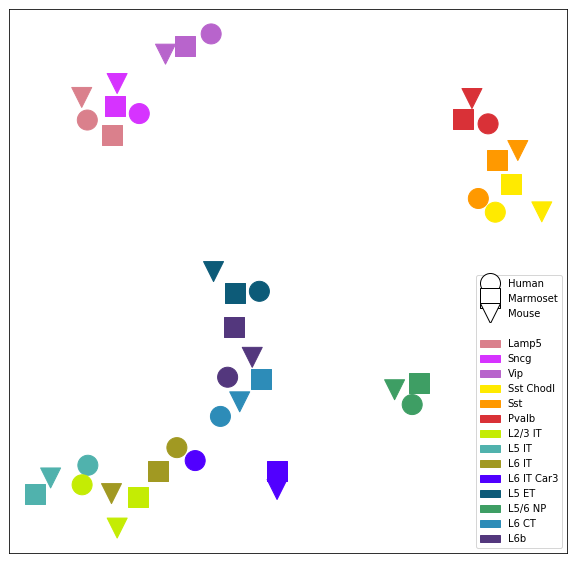

In [13]:
newdf = tmpdf.T
# newdf = transform_1(pqvaldf).T

marker_colors = [marker_color_dict[x] for x in newdf.index.str.split('.',expand=True).droplevel(1).droplevel(1)]

metric = 'cosine'

tsne = TSNE(perplexity=5, metric=metric)
reduced = tsne.fit_transform(newdf)
#     pd.DataFrame(reduced, index = newdf.index, columns=['tsne_0','tsne_1']).to_csv('tf_profile.tsne2.txt')

plt.figure(figsize = (10,10))
mscatter(reduced[:,0], reduced[:,1], m=['o','s','v']*(len(reduced)//3), s=400, c=marker_colors)
plt.gca().legend(handles=legend_elements, loc='lower right')
# for i, txt in enumerate(newdf.index):
#     plt.gca().annotate(txt, (reduced[i,0], reduced[i,1]))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.show()